Implementação do método Gauss-Newton com NLPModels e aplicação nos dados covid.csv

In [1]:
using NLPModels

In [2]:
nlp = ADNLSModel(
    x -> [x[1] * x[2] - 1.0; x[1]^2 + x[2]^2 - 4.0],
    [0.5; 0.7], 2
)

ADNLSModel(Minimization problem Generic
nvar = 2, ncon = 0 (0 linear)
, NLSMeta(2, 2, [0.0, 0.0], 4, 3), NLSCounters(Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 0, 0, 0, 0, 0, 0, 0), var"#3#4"(), NLPModels.var"#6#8"())

In [3]:
residual(nlp, nlp.meta.x0)

2-element Array{Float64,1}:
 -0.65
 -3.26

In [4]:
jac_residual(nlp, nlp.meta.x0)

2×2 Array{Float64,2}:
 0.7  0.5
 1.0  1.4

In [5]:
F(x) = residual(nlp, x)
J(x) = jac_residual(nlp, x)

J (generic function with 1 method)

In [8]:
using LinearAlgebra

x = copy(nlp.meta.x0)
x, norm(F(x)), norm(J(x)' * F(x))

([0.5, 0.7], 3.324169069105842, 6.140321327096815)

In [18]:
d = -(J(x)' * J(x)) \ (J(x)' * F(x))
x = x + d
x, norm(F(x)), norm(J(x)' * F(x))

([0.5176380902050415, 1.9318516525781366], 1.1102230246251565e-16, 2.220446049250313e-16)

In [19]:
x = copy(nlp.meta.x0)

2-element Array{Float64,1}:
 0.5
 0.7

In [27]:
using Krylov

d, krylov_stats = Krylov.lsmr(J(x), -F(x))
x = x + d
x, norm(F(x)), norm(J(x)' * F(x))

([0.5176380902050414, 1.9318516525781368], 8.95090418262362e-16, 3.4470592372182254e-15)

In [385]:
using Krylov, NLPModels, SolverTools # JuliaSmoothOptimizers

function gauss_newton(nls :: AbstractNLSModel;
        α = 0.1,
        atol = 1e-6, rtol = 1e-6, max_eval = 10_000, max_time = 60.0)
    x = copy(nls.meta.x0)
    F(x) = residual(nls, x)
    J(x) = jac_residual(nls, x)
    
    Fx = F(x)
    Jx = J(x)
    JᵀF = Jx' * Fx
    
    ϵ = atol + rtol * norm(JᵀF)
    start_time = time()
    Δt = 0.0
    
    solved = norm(JᵀF) < ϵ
    tired = neval_residual(nls) > max_eval || Δt > max_time
    
    while !(solved || tired)
        d, krylov_stats = lsmr(Jx, -Fx)
        x += α * d
        
        Fx = F(x)
        Jx = J(x)
        JᵀF = Jx' * Fx
        
        Δt = time() - start_time
        solved = norm(JᵀF) < ϵ
        tired = neval_residual(nls) > max_eval || Δt > max_time
    end
    
    status = :unknown
    if solved
        status = :first_order
    elseif tired
        if Δt > max_time
            status = :max_time
        else
            status = :max_eval
        end
    end
    
    return GenericExecutionStats(status, nls, solution=x, dual_feas=norm(JᵀF),
                                 elapsed_time=Δt, objective=dot(Fx, Fx) / 2)
end

gauss_newton (generic function with 1 method)

In [384]:
SolverTools.show_statuses()

STATUSES:
  :acceptable     => solved to within acceptable tolerances
  :exception      => unhandled exception
  :first_order    => first-order stationary
  :infeasible     => problem may be infeasible
  :max_eval       => maximum number of function evaluations
  :max_iter       => maximum iteration
  :max_time       => maximum elapsed time
  :neg_pred       => negative predicted reduction
  :not_desc       => not a descent direction
  :small_residual => small residual
  :small_step     => step too small
  :stalled        => stalled
  :unbounded      => objective function may be unbounded from below
  :unknown        => unknown
  :user           => user-requested stop


In [386]:
nls = ADNLSModel(
    x -> [x[1] * x[2] - 1.0; x[1]^2 + x[2]^2 - 4.0],
    [0.5; 0.7], 2
)

output = gauss_newton(nls)

"Execution stats: first-order stationary"

In [387]:
print(output)

Generic Execution stats
  status: "first-order stationary"
  objective value: 1.3742013128069374e-12
  primal feasibility: 0.0
  dual feasibility: 6.864157090622998e-6
  solution: [0.5176380043262384  1.9318512573626214]
  iterations: -1
  elapsed time: 0.0006451606750488281


In [399]:
nls = ADNLSModel(
    x -> [x[1] - 1.0; 10 * (x[2] - x[1]^2)],
    [-1.2; 1.0], 2
)

output = gauss_newton(nls, α = 1.0)
print(output)

Generic Execution stats
  status: "first-order stationary"
  objective value: 3.4910339246502494e-25
  primal feasibility: 0.0
  dual feasibility: 1.8699247906322293e-11
  solution: [0.9999999999999658  1.000000000000015]
  iterations: -1
  elapsed time: 5.602836608886719e-5


In [400]:
neval_residual(nls)

3

In [395]:
A = rand(10, 3)
b = rand(10)
nls = ADNLSModel(x -> A * x - b, zeros(3), 10)

output = gauss_newton(nls, α = 1.0)
print(output)

Generic Execution stats
  status: "first-order stationary"
  objective value: 0.4489276974679337
  primal feasibility: 0.0
  dual feasibility: 1.9008628166288058e-13
  solution: [-0.07005677942035861  0.9114550457707855  -0.047297441804754106]
  iterations: -1
  elapsed time: 7.295608520507812e-5


In [396]:
neval_residual(nls)

2

## Dados do COVID

In [401]:
using CSV, DataFrames

data = CSV.read("covid.csv")
rename!(data, Dict(
        Symbol("Countries and territories") => "CountryExp",
        :Cases => "NewConfCases"
    ))
df = data[findall(data[!,:CountryExp] .== "Italy"),:]
y = reverse(df.NewConfCases)
y = cumsum(y[findlast(y .== 0)+1:end])

n = length(y)
x = range(0, 1, length=n)

h(β, x) = β[3] / (1 + exp(-β[1] - β[2] * x))
nls = ADNLSModel(
    β -> [y[i] - h(β, x[i]) for i = 1:n],
    [-5.53; 5.76; 4e4], n
)

ADNLSModel(Minimization problem Generic
nvar = 3, ncon = 0 (0 linear)
, NLSMeta(25, 3, [0.0, 0.0, 0.0], 75, 6), NLSCounters(Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 0, 0, 0, 0, 0, 0, 0), var"#54#56"(), NLPModels.var"#6#8"())

In [402]:
residual(nls, nls.meta.x0)

25-element Array{Float64,1}:
 -144.01288618111252
 -124.65873714096207
 -125.74062027262167
  -97.28034501301562
  -91.07089093487843
 -122.85666231413438
  -11.54579054625151
   51.54621925278343
   71.4272149886649 
  356.1476464210357 
  156.53571768829215
  392.995262587885  
  446.4396203512497 
  558.4672748834896 
  533.9186622361076 
  809.9767951143713 
 1140.9663950501063 
 1568.9373593874816 
  957.9579618640746 
 1463.7799115929283 
 2102.2109032925455 
 2461.257293723609  
  234.0600354319322 
 4076.9991666750066 
 5687.085816057781  

In [403]:
F(β) = residual(nls, β)
J(β) = jac_residual(nls, β)
β = copy(nls.meta.x0)

3-element Array{Float64,1}:
    -5.53
     5.76
 40000.0 

In [408]:
reset!(nls)
output = gauss_newton(nls, atol=1e-12, rtol=1e-12)
β = output.solution
print(output)

Generic Execution stats
  status: "maximum number of function evaluations"
  objective value: 4.4688635649275e6
  primal feasibility: 0.0
  dual feasibility: 1.0873342719422732
  solution: [-5.73117604392885  5.057879880801879  80835.9720485137]
  iterations: -1
  elapsed time: 0.19988489151000977


In [409]:
y_pred = [h(β,xi) for xi in x]

25-element Array{Float64,1}:
   261.3245933691231 
   322.3861880646415 
   397.6451364527162 
   490.36579268103856
   604.5440416377118 
   745.0613643564338 
   917.8662093968711 
  1130.184753411804  
  1390.7616176283746 
  1710.1283976379402 
  2100.893411964594  
  2578.0391849980288 
  3159.2040500598127 
  3864.9101078317285 
  4718.681129008411  
  5746.971207154713  
  6978.800096130133  
  8444.969125400341  
 10176.721463476424  
 12203.72631150056   
 14551.326246363134  
 17237.107448626346  
 20267.040224236443  
 23631.673118209077  
 27303.09067090625   

In [410]:
using Plots
gr()

Plots.GRBackend()

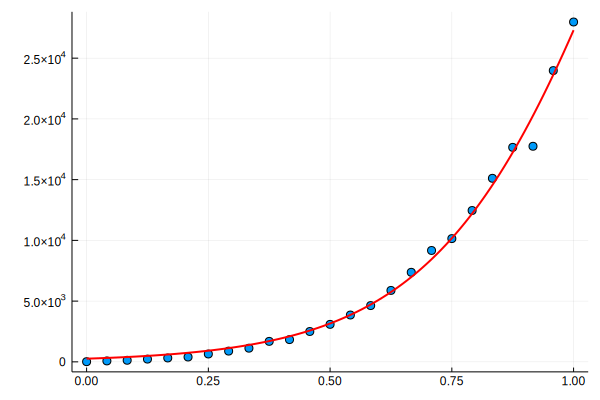

In [411]:
scatter(x, y, leg=false)

xg = range(0, 1.0, length=100)
hx = [h(β, xi) for xi in xg]

plot!(xg, hx, c=:red, lw=2)